<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/himmelblau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Himmelblau Function (Test Functions for Optimization)**

In [0]:
import tensorflow as tf
import datetime, os
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import math 

print(tf.__version__)

2.2.0


List of Optimization Algorithms<br>
https://en.m.wikipedia.org/wiki/List_of_algorithms#Optimization_algorithms

List of Test Functions for Optimization <br> https://en.m.wikipedia.org/wiki/Test_functions_for_optimization

## **Himmelblau**

https://en.wikipedia.org/wiki/Himmelblau%27s_function

$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$

The Himmelblau's function has one local maximum at $(x,y) = (-0.270845, -0.923039)$ where $f(x,y)=181.617$, and four identical local minima:

$
f(3.0,2.0)=0 \\
f(-2.805118,3.131312)=0 \\
f(-3.779310,-3.283186)=0 \\ 
f(3.584428,-1.848126)=0
$

In [0]:
def himmelblau(X):
    x, y = X
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def himmelblau_grad(X):
    x, y = X
    return np.array([
        4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7),
        2 * (x**2 + y - 11) + 4 * y * (x + y**2 - 7)
    ])

def himmelblau_hess(X):
    x, y = X
    return np.array([
        [2 - 400 * (y - 3 * x**2), -400 * x],
        [-400 * x, 200]
    ])

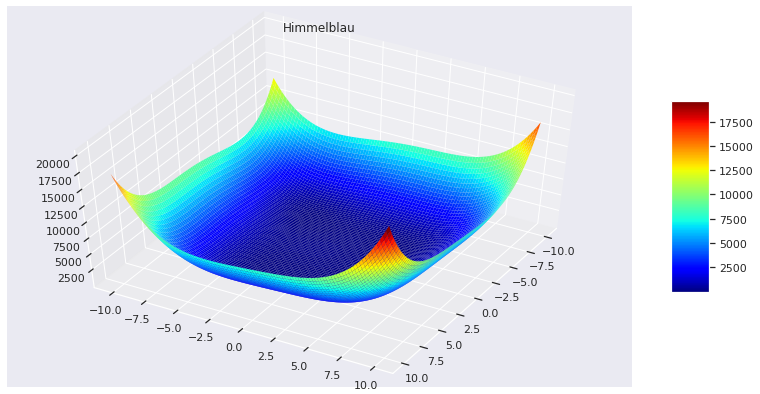

In [0]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = himmelblau((X, Y))

fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection='3d')
ax.set_title('Himmelblau')
ax.view_init(elev=50., azim=30)
himmelblau = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='none')
fig.colorbar(himmelblau, shrink=0.5, aspect=5)

## **Derivative Directions**

### **Newton's direction**

$
d = - H_f^{-1}(x) \cdot \nabla_xf(x) \\
H_f(x) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}, \quad
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$


In [0]:
def newton(J_grad, J_hess, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - np.linalg.solve(J_hess(x), J_grad(x))
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# The Himmelblau function takes 2 inputs

x_init = np.zeros(2)
x_min, it = newton(himmelblau_grad, himmelblau_hess, x_init, max_iterations=2000)
print('x* =', x_min)
#print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

x* = [ 3.58445593 -1.84814172]
Grad Himmelblau(x*) = [ 0.00278585 -0.00025377]
Iterations = 2000


### **Gradient's direction**

$
d = - \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$

In [0]:
def gradient_descent(J_grad, x_init, alpha=0.01, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
x_min, it = gradient_descent(himmelblau_grad, x_init)
print('x* =', x_min)
# print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

x* = [3. 2.]
Grad Himmelblau(x*) = [-3.28554961e-11  7.93143329e-11]
Iterations = 93


### **Gradient's direction + Optimal step size**

$
d = - \alpha \nabla_xf(x) \\
\nabla_xf(x) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}, \quad \alpha \in {\Bbb R}
$

$\alpha$ is the step size, usually in the range $[0,1]$. Unlike the usual gradient descent, here we want to find the optimal $\alpha$ at every iteration. Since at every step, the update is:

$x_{k+1} = x_k - \alpha \nabla_xf(x_k)$

We want to make sure, that the chosen $\alpha$ is going to minimize as much as possible the target function $f$. Therefore, we want $\alpha$ to be such that:

$\alpha_k = \underset{\alpha}{argmin} f(x_k - \alpha \nabla_xf(x_k))$

Since at iteration $k$, $x_k$ and $\nabla_xf(x_k)$ are constants, we can define $q(\alpha)$:

$q(\alpha) = f(x_k - \alpha \nabla_xf(x_k))$

that is a function of one variable, $\alpha$. Therefore, we want to find the right $\alpha$ that will minimize $q$. That task can be solved for instance using gradient descent itself, but since we know that $/alpha$ is bounded, we are going to use another algorithm more suited for this task: Golden Section Search.

https://en.wikipedia.org/wiki/Golden-section_search

In [0]:
def gss(f, a, b, tol=1e-7):
    phi = (np.sqrt(5) + 1) / 2
    d = b - (b - a) / phi
    c = a + (b - a) / phi

    while abs(d - c) > tol:
        if f(d) < f(c):
            b = c
        else:
            a = d

        d = b - (b - a) / phi
        c = a + (b - a) / phi

    return (a + b) / 2

def gradient_descent_optimal(J, J_grad, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        q = lambda alpha: J(x - alpha * J_grad(x))
        alpha = gss(q, 0, 1)
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

In [0]:
# The Himmelblau function takes 2 inputs
x_init = np.zeros(2)
# x_min, it = gradient_descent_optimal(himmelblau, himmelblau_grad, x_init)
print('x* =', x_min)
# print('Himmelblau(x*) =', himmelblau(x_min))
print('Grad Himmelblau(x*) =', himmelblau_grad(x_min))
print('Iterations =', it)

x* = [3. 2.]
Grad Himmelblau(x*) = [-3.28554961e-11  7.93143329e-11]
Iterations = 93
